<span style="color:#000000; font-size:1.2em; text-align:right">Data Scientist II Technical Challenge</span>

<span style="color:#e01760; font-size:2em; align=center">Task 3: Natural Language Processing</span>

<font color="#6E6E6E" align="center">Cristina M. Sánchez Maíz | csmaiz@gmail.com | [LinkedIn](https://www.linkedin.com/in/csmaiz/) </font> 

**Tasks:**

Using the Customer Reviews dataset:
- Preprocess the text data (e.g., tokenization, stopword removal, stemming/lemmatization).
- Perform sentiment analysis on the reviews.
- Visualize the distribution of sentiment scores.

**Deliverables:**
- Preprocessed text data.
- Sentiment analysis results.
- Visualizations of sentiment distribution.

# Import libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Libraries for NLP
import re
from textblob import TextBlob
import nltk 
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer, WordNetLemmatizer

# For evaluating techniques
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
  confusion_matrix, roc_curve, auc, precision_recall_curve

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [15]:
pd.set_option('display.max_colwidth', None) # avoid truncate columns content
# Color for graphs
PINK_RGB = "#e01760"
DARK_BLUE = "#03396f"
MED_BLUE = "#0341cd"

# Load dataset

In [17]:
# Run a Linux command to get the header and the first two rows of the dataset
! head -n5 ./input/customer_reviews_with_errors.csv 

review_id,customer_id,review_date,review_text
1,74,,
2,2,2023-10-16,"Terrible service, will not buy from here again."
3,44,2023-12-08,"Average quality, you get what you pay for."
4,6,2024-06-08,"Great product, very satisfied with the quality and performance."


In [18]:
df = pd.read_csv("./input/customer_reviews_with_errors.csv",delimiter=",")
df.head(10)

,review_id,customer_id,review_date,review_text
0,1,74,NaN,NaN
1,2,2,2023-10-16,"Terrible service, will not buy from here again."
2,3,44,2023-12-08,"Average quality, you get what you pay for."
3,4,6,2024-06-08,"Great product, very satisfied with the quality and performance."
4,5,46,2024-07-30,"Very disappointed with the product, not as described."
5,6,43,2023-11-16,"Excellent service, highly recommend!"
6,7,18,2023-10-20,The item arrived damaged and customer service was unhelpful.
7,8,8,2024-03-09,Fast delivery and the product works perfectly!
8,9,57,2023-12-19,The item arrived damaged and customer service was unhelpful.
9,10,65,2024-01-13,"The service was acceptable, but could be improved."


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    1010 non-null   int64 
 1   customer_id  1010 non-null   int64 
 2   review_date  989 non-null    object
 3   review_text  989 non-null    object
dtypes: int64(2), object(2)
memory usage: 31.7+ KB


In [20]:
print(df.isnull().sum())  # Count missing values in each column

review_id       0
customer_id     0
review_date    21
review_text    21
dtype: int64


In [21]:
df = df.dropna(subset=['review_text'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 989 entries, 1 to 1009
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    989 non-null    int64 
 1   customer_id  989 non-null    int64 
 2   review_date  989 non-null    object
 3   review_text  989 non-null    object
dtypes: int64(2), object(2)
memory usage: 38.6+ KB


# Explore the dataset

In [22]:
df.describe(include=[np.number])

,review_id,customer_id
count,989.000000,989.000000
mean,496.495450,51.189080
std,291.310937,28.358778
min,2.000000,1.000000
25%,244.000000,28.000000
50%,496.000000,53.000000
75%,748.000000,75.000000
max,1000.000000,100.000000


In [23]:
# Identifiers are stored as object to avoid using them in operations and visualizations
# Using integers as data types improve performance and storage efficiency but since the dataset is small we can use object type 
ID_COLUMNS = ["customer_id", "review_id"]
print("The dataset contains {} id columns: {}".format(len(ID_COLUMNS), ",".join(ID_COLUMNS)))

The dataset contains 2 id columns: customer_id,review_id


In [24]:
for col_ in ID_COLUMNS:
    df[col_] = df[col_].astype(object)
    print("Column '{}' has {} duplicates values".format(col_,
                                  df[col_].duplicated().sum()))

Column 'customer_id' has 889 duplicates values
Column 'review_id' has 9 duplicates values


<font color="black"> Notes on the uniqueness of the identifiers: </font>

- Column `customer_id` is allowed to appear more than once since a customer can perform more than one transaction
- Each review is assigned an unique identifier and, therefore, column `review_id` must not have duplicated values. `review_id` is the primary key in the reviews dataset.

In [25]:
# First of all, take rid of duplicated rows and repeat the check
df = df.drop_duplicates()
for col_ in ID_COLUMNS:
    print("Column '{}' has {} duplicates values".format(col_,
                                  df[col_].duplicated().sum()))

Column 'customer_id' has 880 duplicates values
Column 'review_id' has 0 duplicates values


# Preprocess the text data


* Tokenization breaks text into individual words.
* Stopword removal eliminates common words with little meaning.
* Stemming reduces words to their root form (simpler).
* Lemmatization reduces words to their root form considering context (more accurate).


In [13]:
# Run only once: Download necessary NLTK data
# punkt: This line downloads the Punkt sentence tokenizer. This model is used to split text sentences into individual words (tokens). It's crucial for most NLP tasks that involve analyzing words.
# stopwords: This line downloads a list of English stopwords. Stopwords are common words like "the", "and", "in" that carry little meaning on their own. Removing them can improve the efficiency and accuracy of NLP models by focusing on more content-rich words.
# wordnet: This line downloads the WordNet lexical database. WordNet is a comprehensive resource that contains information about English words, including synonyms, antonyms, hyponyms (more specific words), and hypernyms (broader categories). It's used for lemmatization.

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('vader_lexicon')


- Lexicon-Based Methods:
Typically benefit from preprocessing: Stop word removal and punctuation removal can improve performance by focusing on the core words.
Lemmatization: Might not be as crucial as with machine learning models, but can still be beneficial.
- Machine Learning Models (NNS)
Almost always benefit from preprocessing: Tokenization, stop word removal, and stemming/lemmatization are essential for converting text into numerical representations that models can understand.
- Large Language Models (LLMs)
Less sensitive to preprocessing: LLMs are often trained on massive amounts of raw text and can handle various text formats.
Experimentation: While preprocessing might not be strictly necessary, it can improve performance in specific cases.


In [26]:

# This function converts the text to lower-case, remove punctuation and stopwords, tokenize and lemmatize.
def preprocess_text(text):
    
    # Lowercase
    text = text.lower()
        
    # Tokenization
    words = nltk.word_tokenize(text)

    # Stop word removal + punctuation removal + lemmatization
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [
        lemmatizer.lemmatize(word) for word in words
        if word.isalpha() and word not in stop_words
    ]
    return ' '.join(words)


# Apply preprocessing to the 'review_text' column
df['preprocessed_review'] = df['review_text'].apply(preprocess_text)



In [27]:
df.head(3) 


,review_id,customer_id,review_date,review_text,preprocessed_review
1,2,2,2023-10-16,"Terrible service, will not buy from here again.",terrible service buy
2,3,44,2023-12-08,"Average quality, you get what you pay for.",average quality get pay
3,4,6,2024-06-08,"Great product, very satisfied with the quality and performance.",great product satisfied quality performance


#TODO Pending work:
- Handling contractions: Consider expanding contractions like "can't" to "cannot".
- Handling numbers: Decide how to handle numbers (e.g., remove, convert to text).
- Handling special characters: Remove or replace special characters that might cause issues.
- Custom stop words: Create a custom list of stop words based on your dataset.

# Sentiment Analysis
- Choose a sentiment analysis technique (e.g., lexicon-based, machine learning, deep learning).
- Apply the chosen method to assign sentiment scores to each review.
- Consider using pre-trained models or building your own model.

## Lexicon-based methods

Rely on sentiment lexicons (pre-built dictionaries of words and their associated sentiment scores).
Simpler to implement but often less accurate than machine learning methods.
Examples: VADER, TextBlob.



In [28]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# vader_sentiment_scores containing a dictionary with four keys: 'neg', 'neu', 'pos', and 'compound'. 
# The 'compound' score is a normalized sentiment score between -1 (extremely negative) and 1 (extremely positive).
def get_vader_score(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)['compound']
    return sentiment

def get_textblob_score(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

def vader_label(score):
    if score >= 0.05:
        return 'positive'
    else:
        return 'negative'

def textblob_label(score):
    if score > 0.05:
        return 'positive'
    else:
        return 'negative'



df['vader_score'] = df['preprocessed_review'].apply(get_vader_score)
df['textblob_score'] = df['preprocessed_review'].apply(get_textblob_score)

df['vader_label'] = df['vader_score'].apply(vader_label)
df['textblob_label'] = df['textblob_score'].apply(textblob_label)



df[["review_text", "preprocessed_review", "vader_score", "textblob_score", "vader_label", "textblob_label"]].drop_duplicates()

,review_text,preprocessed_review,vader_score,textblob_score,vader_label,textblob_label
1,"Terrible service, will not buy from here again.",terrible service buy,-0.4767,-1.000000,negative,negative
2,"Average quality, you get what you pay for.",average quality get pay,-0.1027,-0.150000,negative,negative
3,"Great product, very satisfied with the quality and performance.",great product satisfied quality performance,0.7845,0.650000,positive,positive
4,"Very disappointed with the product, not as described.",disappointed product described,-0.4767,-0.750000,negative,negative
5,"Excellent service, highly recommend!",excellent service highly recommend,0.7574,0.580000,positive,positive
6,The item arrived damaged and customer service was unhelpful.,item arrived damaged customer service unhelpful,-0.4404,0.000000,negative,negative
7,Fast delivery and the product works perfectly!,fast delivery product work perfectly,0.6369,0.600000,positive,positive
9,"The service was acceptable, but could be improved.",service acceptable could improved,0.6597,0.000000,positive,negative
10,"Decent product, but there are better options available.",decent product better option available,0.4404,0.355556,positive,positive
13,"Poor quality, would not recommend.",poor quality would recommend,-0.1531,-0.400000,negative,negative


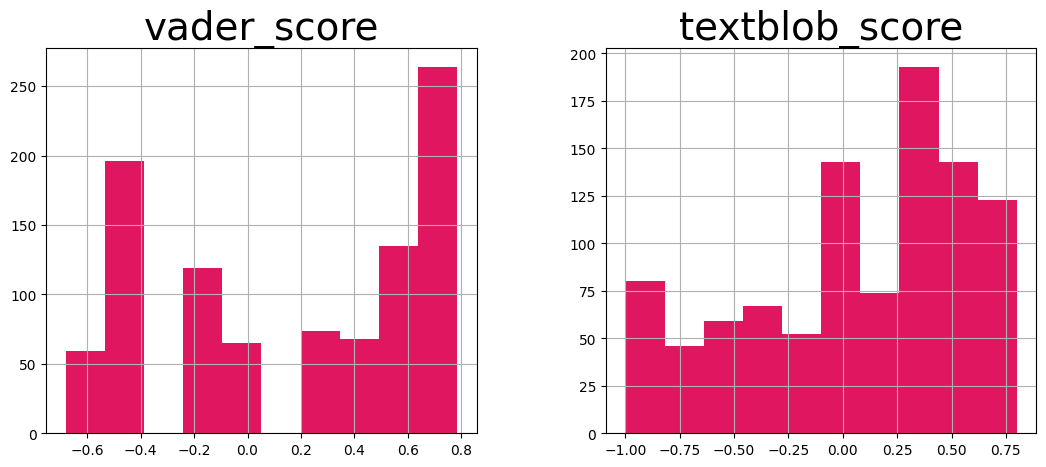

In [29]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def classify_sentiment(score):
    if score >= 0.05:
        return 1  # Like
    else:
        return 0  # Dislike

# Assuming your DataFrame is named 'df'
df['vader_prediction'] = df['vader_score'].apply(lambda ss: classify_sentiment(ss))



Future work:
- Threshold Optimization: Experiment with different thresholds for the Vader score to find the optimal cutoff.
- Calibration: Consider calibrating the Vader scores using logistic regression or other techniques to improve performance.
- Data Imbalance: If your dataset is imbalanced (more likes or dislikes), consider using appropriate evaluation metrics like F1-score or precision-recall curve.
- Domain-Specific Lexicon: Create a custom lexicon tailored to your domain for better sentiment analysis.

## Train models on labeled data to classify text as positive, negative, or neutral.

Generally more accurate than lexicon-based methods but require labeled data.

Examples: Naive Bayes, SVMs, Recurrent Neural Networks (RNNs), Long Short-Term Memory (LSTM).

1. Naive Bayes:
* Simple and efficient algorithm.
* Works well with text data.
2. Support Vector Machines (SVM):
* Effective for classification tasks.
* Can handle high-dimensional data.
3. Recurrent Neural Networks (RNNs):
* Capture sequential dependencies in text.
* Suitable for longer text sequences.
4. Long Short-Term Memory (LSTM):
* A type of RNN that addresses the vanishing gradient problem.
* Better at capturing long-term dependencies.


## Large language model

In [27]:
import os
os.environ["http_proxy"]=""
os.environ["https_proxy"]=""

In [30]:
%%time

# Load the pre-trained model - https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english
# The "distilbert-base-uncased-finetuned-sst-2-english" model is specifically trained for binary sentiment analysis (positive or negative)
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


'''
This function encapsulates the process of converting raw text into a format suitable for the BERT model, 
obtaining the model's prediction, and mapping the numerical prediction to a human-readable 
sentiment label.
'''
def get_bert_score(texts):
    # convert the text to a compatible BERT format and set the output a PyTorch tensor.
    inputs = tokenizer(texts, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    #The model's output is a tensor of logits, representing the unnormalized scores for each class (positive or negative in this case). The argmax() function finds the index of the maximum value (the most probable class), and item() converts it to a Python integer.
    logits = outputs.logits
    predicted_labels  = logits.argmax(-1).tolist()
    scores = torch.softmax(logits, dim=-1)[:, 1].tolist()  
    label_map = {0: "negative", 1: "positive"}
    return [(label_map[label], score) for label, score in zip(predicted_labels, scores)]

# Apply the prediction function to the 'textReview' column
df['bert_pred'] = df['review_text'].apply(get_bert_score)
df['bert_score'] = df['bert_pred'].apply(lambda bb: bb[0][1])
df['bert_label'] = df['bert_pred'].apply(lambda bb: bb[0][0])
df['bert_label_3categ'] = df[['bert_label', 'bert_score']].apply(lambda row: "neutral" if row["bert_score"].between(0.02,0.03) else row["bert_label"])


KeyError: 'bert_score'

In [35]:
df['bert_label_3categ'] = df.apply(lambda row: "neutral" if row["bert_score"]>0.01 and row["bert_score"]<0.03 else row["bert_label"], axis=1)


In [36]:
df[["review_text", "bert_score", "bert_label", "bert_label_3categ"]].drop_duplicates()

,review_text,bert_score,bert_label,bert_label_3categ
1,"Terrible service, will not buy from here again.",0.001188,negative,negative
2,"Average quality, you get what you pay for.",0.591803,positive,positive
3,"Great product, very satisfied with the quality and performance.",0.999857,positive,positive
4,"Very disappointed with the product, not as described.",0.000211,negative,negative
5,"Excellent service, highly recommend!",0.999873,positive,positive
6,The item arrived damaged and customer service was unhelpful.,0.000206,negative,negative
7,Fast delivery and the product works perfectly!,0.999871,positive,positive
9,"The service was acceptable, but could be improved.",0.028429,negative,neutral
10,"Decent product, but there are better options available.",0.979263,positive,positive
13,"Poor quality, would not recommend.",0.000832,negative,negative


# Sentiment Distribution Visualization:

- Create visualizations to represent the distribution of sentiment scores (e.g., histograms, bar charts, word clouds).
- Explore different visualization techniques to effectively communicate insights.

In [47]:
df[["review_text", "preprocessed_review", "vader_score", "textblob_score", "vader_label", "textblob_label", "bert_label", "bert_score"]].drop_duplicates()

,review_text,preprocessed_review,vader_score,textblob_score,vader_label,textblob_label,bert_label,bert_score
1,"Terrible service, will not buy from here again.",terrible service buy,-0.4767,-1.000000,negative,negative,negative,0.001188
2,"Average quality, you get what you pay for.",average quality get pay,-0.1027,-0.150000,negative,negative,positive,0.591803
3,"Great product, very satisfied with the quality and performance.",great product satisfied quality performance,0.7845,0.650000,positive,positive,positive,0.999857
4,"Very disappointed with the product, not as described.",disappointed product described,-0.4767,-0.750000,negative,negative,negative,0.000211
5,"Excellent service, highly recommend!",excellent service highly recommend,0.7574,0.580000,positive,positive,positive,0.999873
6,The item arrived damaged and customer service was unhelpful.,item arrived damaged customer service unhelpful,-0.4404,0.000000,negative,negative,negative,0.000206
7,Fast delivery and the product works perfectly!,fast delivery product work perfectly,0.6369,0.600000,positive,positive,positive,0.999871
9,"The service was acceptable, but could be improved.",service acceptable could improved,0.6597,0.000000,positive,negative,negative,0.028429
10,"Decent product, but there are better options available.",decent product better option available,0.4404,0.355556,positive,positive,positive,0.979263
13,"Poor quality, would not recommend.",poor quality would recommend,-0.1531,-0.400000,negative,negative,negative,0.000832


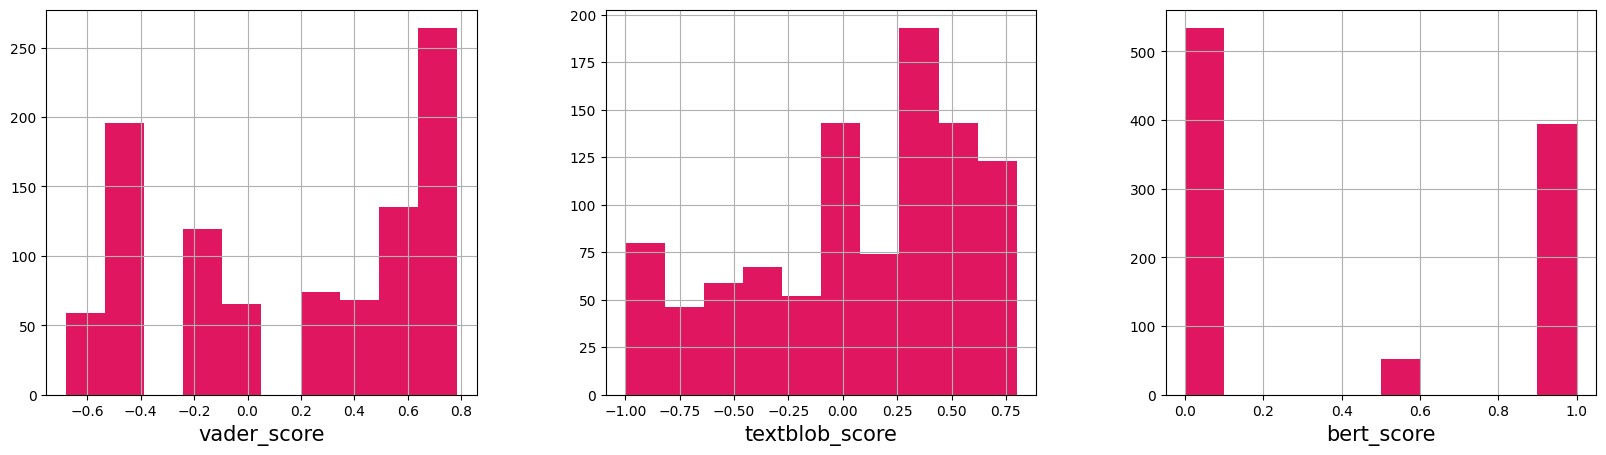

In [52]:

ax = df[["vader_score", "textblob_score", "bert_score"]].hist(bins = 10, 
                     figsize = (20,5), #width, height
                     color = '#e01760', layout=(1,3))

for axs in ax.flatten():
    axs.set_xlabel(axs.get_title(), fontsize=15)  
    axs.set_ylabel(axs.get_ylabel(), fontsize=15) 
    axs.set_title("", fontsize=28)  
    
#plt.title('Distribution of Sentiment Scores')
#plt.xlabel('Sentiment Score')
#plt.ylabel('Count')
plt.grid(True)
plt.show()

In [100]:





def create_visualizations(score_col="score", label=""):
    
    fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(15, 5) )
    fig.suptitle('Scores Distributions - {}'.format(label))


    # Histogram
    sns.histplot(data=df, x=score_col, bins=5, kde=True, ax=axs[0], color=PINK_RGB)
    axs[0].set_xlabel('')

    #plt.show()

    # Density Plot
    sns.kdeplot(data=df, x=score_col, fill=True, ax=axs[1], color=PINK_RGB)
    #axs[0][1].set_title('Density Plot of Sentiment Scores')
    #axs[1].xlabel('Sentiment Score')
    axs[1].set_ylabel('Density')
    axs[1].set_xlabel('')

    #plt.show()

    # Box Plot
    sns.boxplot(x=df[score_col], ax=axs[2], color=PINK_RGB)
    axs[2].set_xlabel('')

    #axs[1][0].title('Box Plot of Sentiment Scores')
    #plt.show()


    
    plt.show()

In [102]:
df.describe()

,vader_score,textblob_score,vader_prediction,bert_score
count,980.000000,980.000000,980.000000,980.000000
mean,0.172274,0.074104,0.552041,0.435535
std,0.508658,0.532050,0.497538,0.477814
min,-0.680800,-1.000000,0.000000,0.000206
25%,-0.440400,-0.400000,0.000000,0.001188
50%,0.202300,0.183333,1.000000,0.028429
75%,0.659700,0.580000,1.000000,0.999857
max,0.784500,0.800000,1.000000,0.999887


In [1]:
create_visualizations(score_col="vader_score", label="Vader")

create_visualizations(score_col="textblob_score", label="TextBlob")

create_visualizations(score_col="bert_score", label="BERT")


NameError: name 'create_visualizations' is not defined

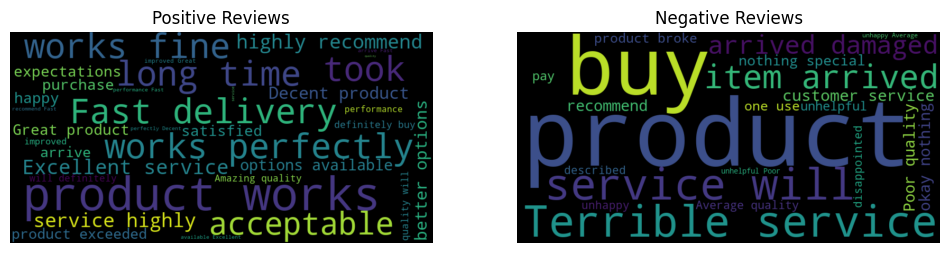

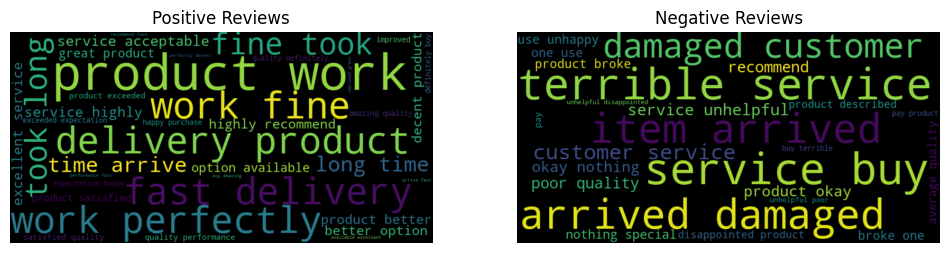

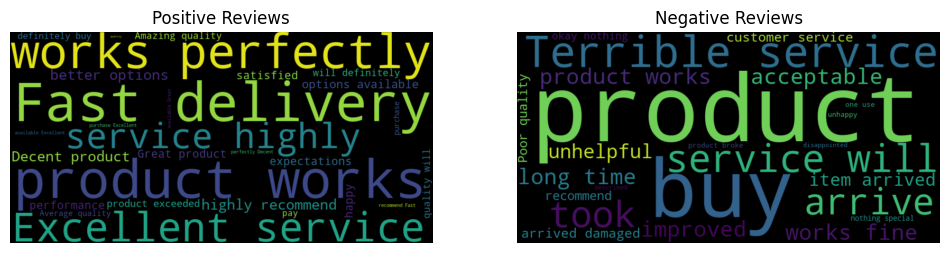

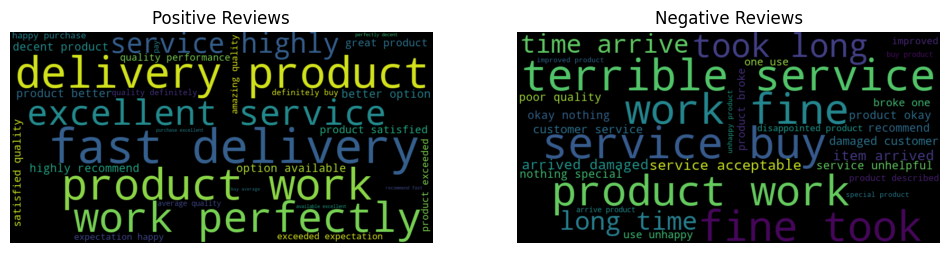

In [105]:

from wordcloud import WordCloud

def generate_word_cloud(label_col, text_col):
    # Create separate DataFrames for positive and negative reviews
    positive_reviews = df[df[label_col] == "positive"]
    negative_reviews = df[df[label_col] == "negative"]

    # Generate word clouds
    wordcloud_positive = WordCloud(width=800, height=400).generate(' '.join(positive_reviews[text_col]))
    wordcloud_negative = WordCloud(width=800, height=400).generate(' '.join(negative_reviews[text_col]))

    # Plot the word clouds
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.axis('off')

    plt.title('Positive Reviews')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.axis('off')
    plt.title('Negative Reviews')

    plt.show()
    

    
    
generate_word_cloud(label_col="vader_label", text_col="review_text")
generate_word_cloud(label_col="vader_label", text_col="preprocessed_review")


generate_word_cloud(label_col="bert_label", text_col="review_text")
generate_word_cloud(label_col="bert_label", text_col="preprocessed_review")

# Generate deliverables

In [2]:
df[["review_text", "preprocessed_review", "vader_label", "bert_label", "bert_label_3categ"]].to_csv("./output/task3/reviews_with_scores.csv", sep=",")

NameError: name 'df' is not defined